In [1]:
import pandas as pd
from pandas import *
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
%matplotlib inline
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error

In [2]:
test= pd.read_csv('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')
# test=pd.read_csv('/home/atif/dataset_26_april_3.csv')

In [3]:
import datetime
longTime=test.loc[0:,['longTime']]
longTime=longTime.as_matrix()
a=[]
date_time_array=[]
for k in longTime:
    a=np.append(a,k)
str_time=[]
correct_longtime=[]
datetime_time=[]
count=0
for b in a:
    b=int(b) # make plain integer
    str_b=str(b)
    c=str_b[-3:]
    new_str_b=str_b.replace(c, '',1)
    new_str_b_time=int(new_str_b)
    correct_longtime.append(new_str_b_time)
    now_time=datetime.datetime.fromtimestamp(new_str_b_time)
    convert_time=now_time.strftime('%Y-%m-%d %H:%M')
    str_time.append(convert_time)
# print(str_time)
test_new = test.assign(stringTime=str_time,correct_longtime=correct_longtime) # here new column in the panda dataframe for string_time has added

/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
test_new['dateTime'] =  pd.to_datetime(test_new['stringTime'], format='%Y-%m-%d %H:%M')

In [5]:
test_new.shape #ROWS, COLUMNS

(25000, 4223)

In [34]:
# univariate_data=test_new.loc[500:24999,['dateTime','AEDAHO_T9_V2']]
univariate_data=test_new.loc[700:730,['dateTime','AEDAHO_T9_V2']]
univariate_data = univariate_data.set_index('dateTime')

shape of univariate_data:  (31, 1)


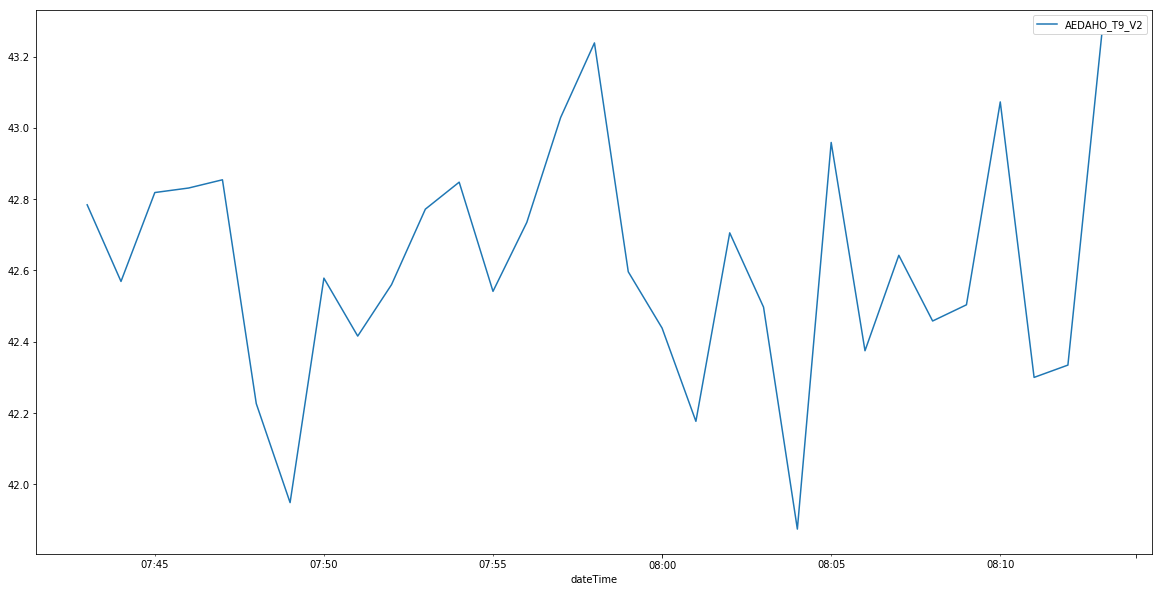

In [35]:
from matplotlib.pylab import rcParams
print('shape of univariate_data: ',univariate_data.shape)
univariate_data.plot()
plt.rcParams['figure.figsize'] =(20,10)
plt.show()

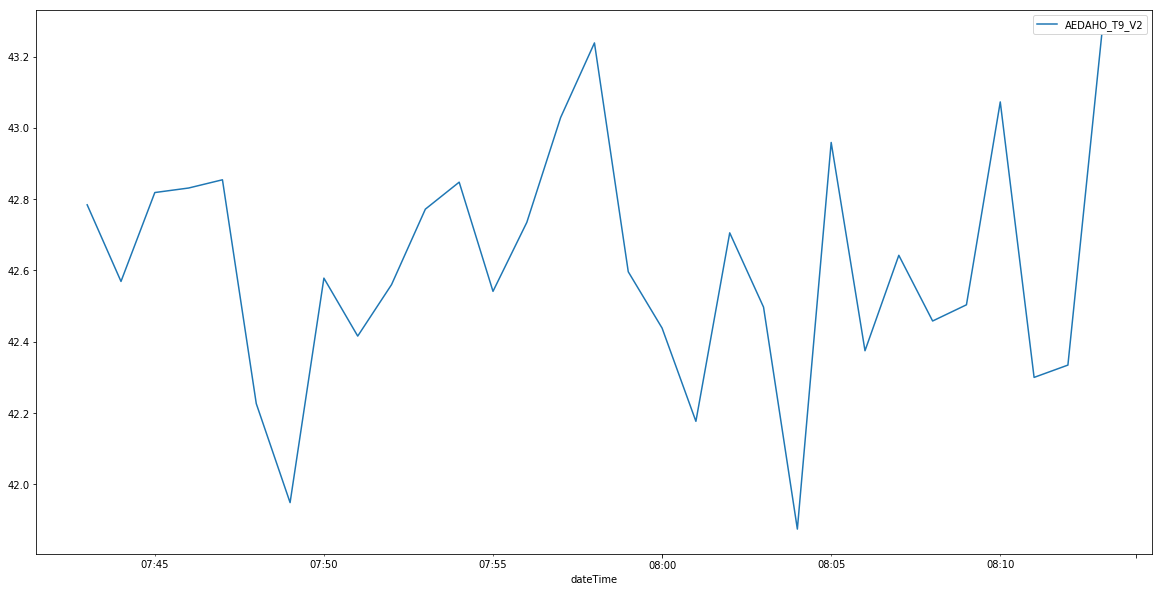

In [36]:
from numpy import nan
univariate_data_drop_zero= univariate_data.replace(0,nan)
univariate_data_drop_zero= univariate_data_drop_zero.dropna(how='any',axis=0)

univariate_data_drop_zero.plot()
plt.show()

In [37]:
dataset=univariate_data_drop_zero.values
print(type(dataset))
# print(dataset)
print('length of dataset: ',len(dataset))

<class 'numpy.ndarray'>
length of dataset:  31


In [38]:
NumberOfElements=int(len(dataset)*0.8)
print(NumberOfElements)

24


In [39]:
train_set=dataset[0:NumberOfElements]
test_set=dataset[NumberOfElements:len(dataset)]

In [40]:
print('Train data shape:',train_set.shape,'\tsize:',train_set.size)
print('Test data shape:',test_set.shape,'\tsize:',test_set.size)

Train data shape: (24, 1) 	size: 24
Test data shape: (7, 1) 	size: 7


In [41]:
Actual = [x for x in train_set]
Predictions = list()

In [60]:
#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
#     model_fit.save('model.pkl')
    prediction = model_fit.forecast()[0]
    return prediction

In [ ]:
for timepoint in range(len(test_set)):
    ActualValue =  test_set[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, 2,1,2) 
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)

In [45]:
from sklearn.metrics import mean_squared_error

#Print MSE to see how good the model is
Error = mean_squared_error(test_set, Predictions)
print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)

print("size of prediction: ",len(Predictions))
print("size of actual: ",len(Actual))

Test Mean Squared Error (smaller the better fit): 0.145
size of prediction:  7
size of actual:  31
